# ARIMA - OHLC

***Reference:*** https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima



## Prepare the data


### Check the data and its stationarity

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [6]:
dateparse= lambda dates: pd.datetime.strptime(dates,'%Y-%m-%d')
stock_data=pd.read_csv("./Dataset/HSBC_Set01/ohlc.csv", index_col='Date', parse_dates=['Date'],date_parser=dateparse)
stock_data

/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_7502/2673466917.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse= lambda dates: pd.datetime.strptime(dates,'%Y-%m-%d')


,Open,High,Low,Close
Date,,,,
2024-01-03,268,313,250,297
2024-01-04,298,344,289,314
2024-01-05,298,316,274,288
2024-01-08,294,295,231,250
2024-01-09,241,267,226,252
...,...,...,...,...
2024-06-24,90,109,90,108
2024-06-25,105,110,90,103
2024-06-26,105,110,90,106


Visualize the per day closing price of the stock.

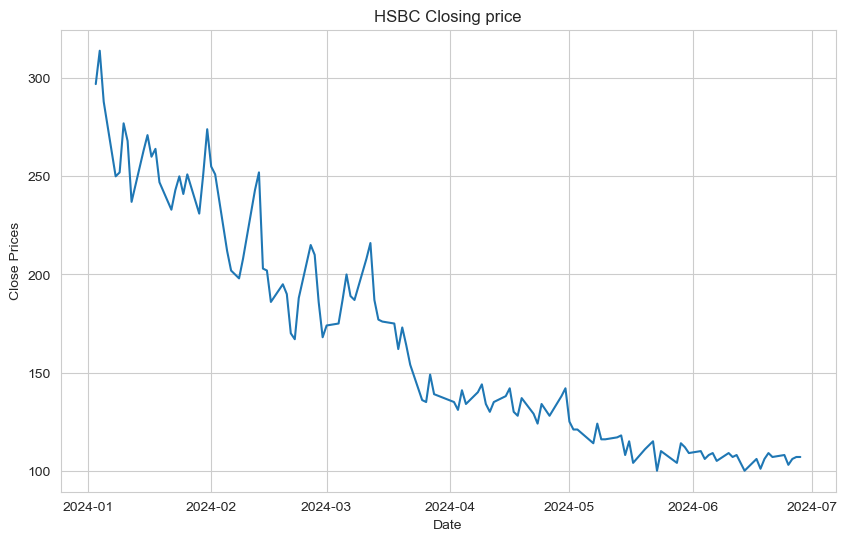

In [7]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('HSBC Closing price')
plt.show()

We can also visualize the data in our series through a probability distribution too.

<Axes: ylabel='Density'>

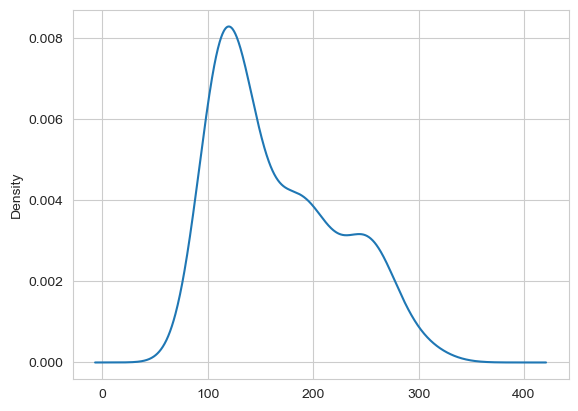

In [8]:
# Distribution of the dataset

df_close=stock_data['Close']
df_close.plot(kind='kde')

#### Check the stationarity

Using the ADF test to check if a series is stationary or not because time series analysis only works with stationary data

In [9]:
def test_stationarity(timeseries):
    print("Results for dickey fuller test")
    results=adfuller(timeseries, autolag='AIC')
    output=pd.Series(results[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in results[4].items():
        output['critical value (%s)'%key] =values
    print(output)

In [10]:
test_stationarity(df_close)

Results for dickey fuller test
Test Statistics                 -1.939472
p-value                          0.313726
No. of lags used                11.000000
Number of observations used    112.000000
critical value (1%)             -3.490131
critical value (5%)             -2.887712
critical value (10%)            -2.580730
dtype: float64


Through the above graph, we can see the decreasing mean and standard deviation and hence our series is not stationary.

Text(0.5, 1.0, '2 order differencing')

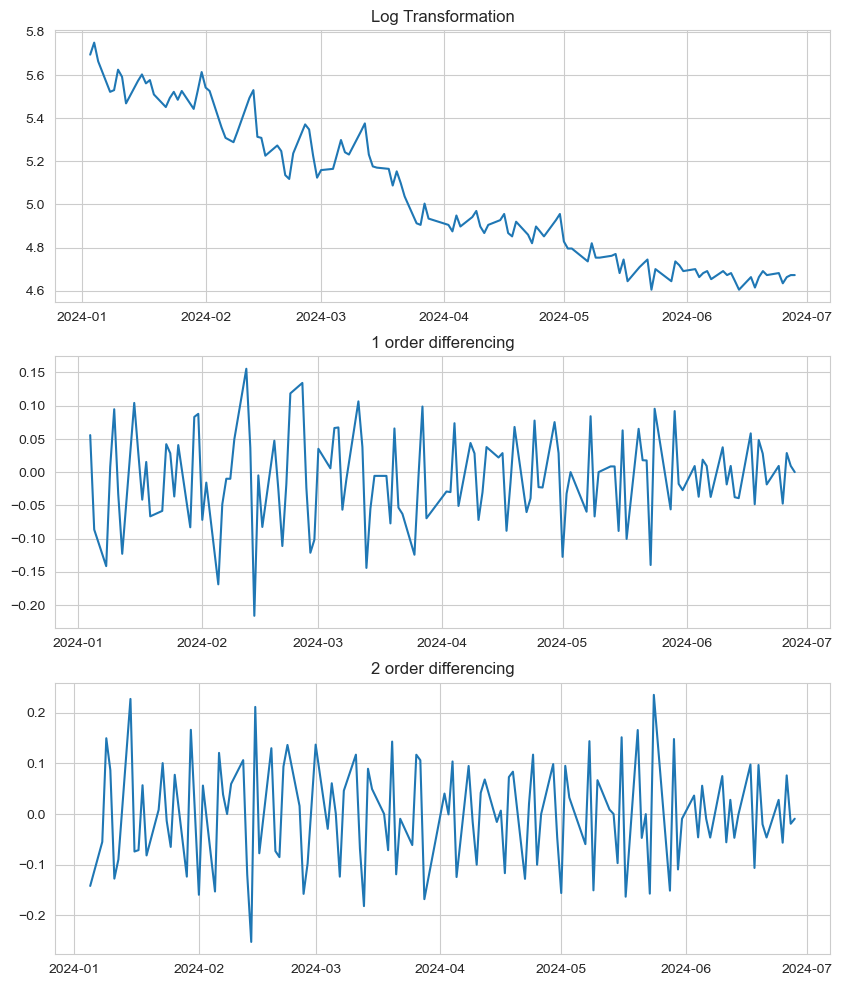

In [14]:
# # Nomalization
# avg, dev=df_close.mean(),df_close.std()
# df_nomal=(df_close-avg)/dev
# df_nomal.plot()
# # Log transformation
df_log=np.log(df_close)
fig,axe = plt.subplots(3,1, figsize=(10,12))
axe[0].plot(df_log)
axe[0].set_title('Log Transformation')
# Take first difference to remove the trend
df_diff=df_log.diff().dropna()
axe[1].plot(df_diff)
axe[1].set_title('1 order differencing')

df_diff_2=df_diff.diff().dropna()
axe[2].plot(df_diff_2)
axe[2].set_title('2 order differencing')

In [8]:
test_stationarity(df_diff)

Results for dickey fuller test
Test Statistics                 -2.954374
p-value                          0.039381
No. of lags used                12.000000
Number of observations used    110.000000
critical value (1%)             -3.491245
critical value (5%)             -2.888195
critical value (10%)            -2.580988
dtype: float64


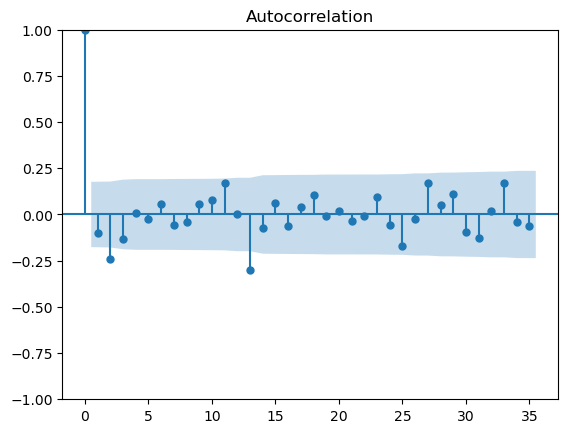

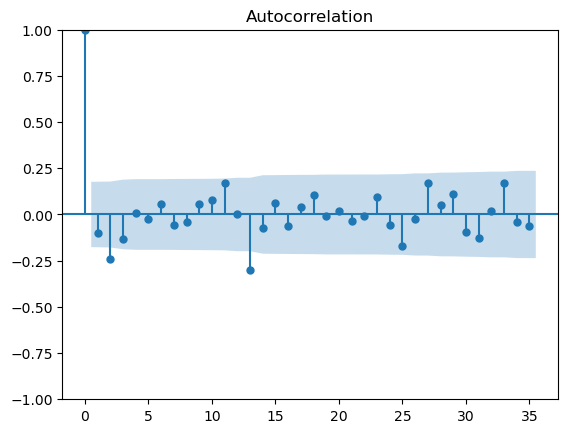

In [9]:
n_lags=35
plot_acf(df_diff,lags=n_lags, alpha=0.05)

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


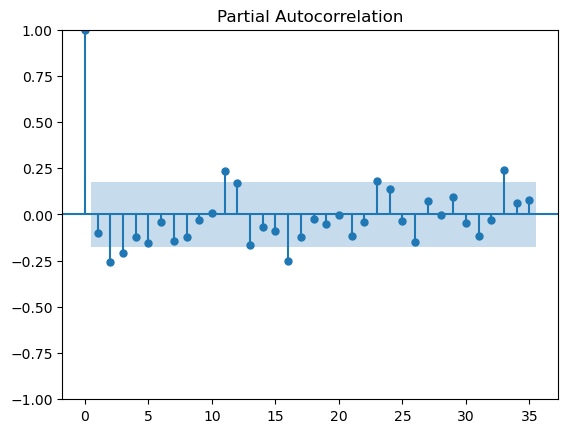

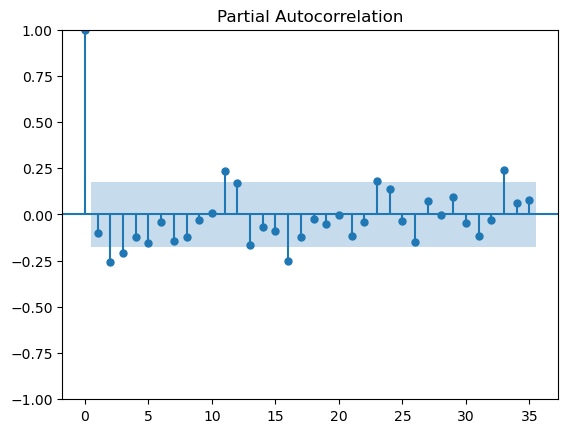

In [10]:
plot_pacf(df_diff,lags=n_lags)

In [11]:
# plot_pacf(df_diff,lags=n_lags,method='ols')

### Split data

In [12]:
def train_test_split(df,size=0.9):
    train_data, test_data=df[:int(len(df)*size)], df[int(len(df)*size):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df,'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()
    return train_data, test_data

DatetimeIndex(['2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-15', '2024-01-16',
               ...
               '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20',
               '2024-06-21', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', name='Date', length=124, freq=None)


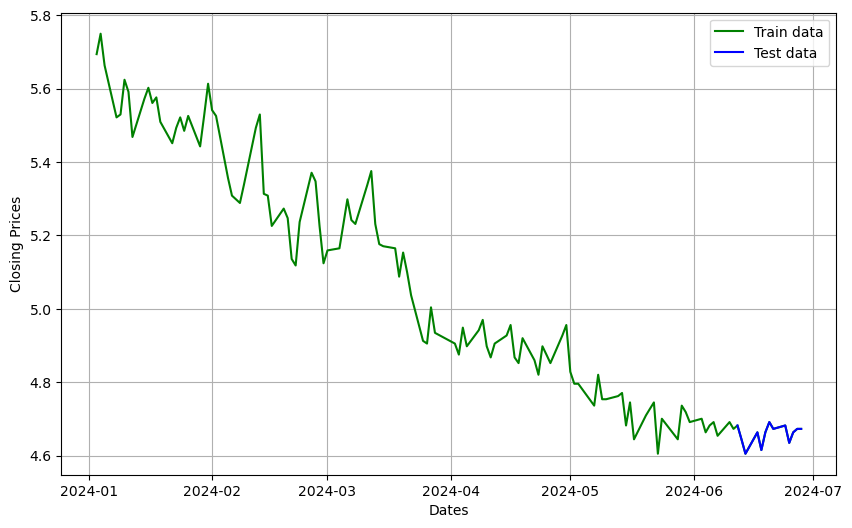

In [13]:
print(df_log.index)
train_data,test_data=train_test_split(df_log, 0.9)

In [14]:
train_data

Date
2024-01-03    5.693732
2024-01-04    5.749393
2024-01-05    5.662960
2024-01-08    5.521461
2024-01-09    5.529429
                ...   
2024-06-05    4.682131
2024-06-06    4.691348
2024-06-07    4.653960
2024-06-10    4.691348
2024-06-11    4.672829
Name: Close, Length: 111, dtype: float64

In [15]:
test_data

Date
2024-06-12    4.682131
2024-06-13    4.644391
2024-06-14    4.605170
2024-06-17    4.663439
2024-06-18    4.615121
2024-06-19    4.663439
2024-06-20    4.691348
2024-06-21    4.672829
2024-06-24    4.682131
2024-06-25    4.634729
2024-06-26    4.663439
2024-06-27    4.672829
2024-06-28    4.672829
Name: Close, dtype: float64

## Model Selection

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

AIC for ARIMA(2,1,2):-271.7359332668338
AIC for ARIMA(2,1,11):-270.24549526522736
AIC for ARIMA(3,1,2):-270.23840106526103
AIC for ARIMA(3,1,11):-266.9038764691473
AIC for ARIMA(11,1,2):-270.8995997117819
AIC for ARIMA(11,1,11):-259.11338536203954


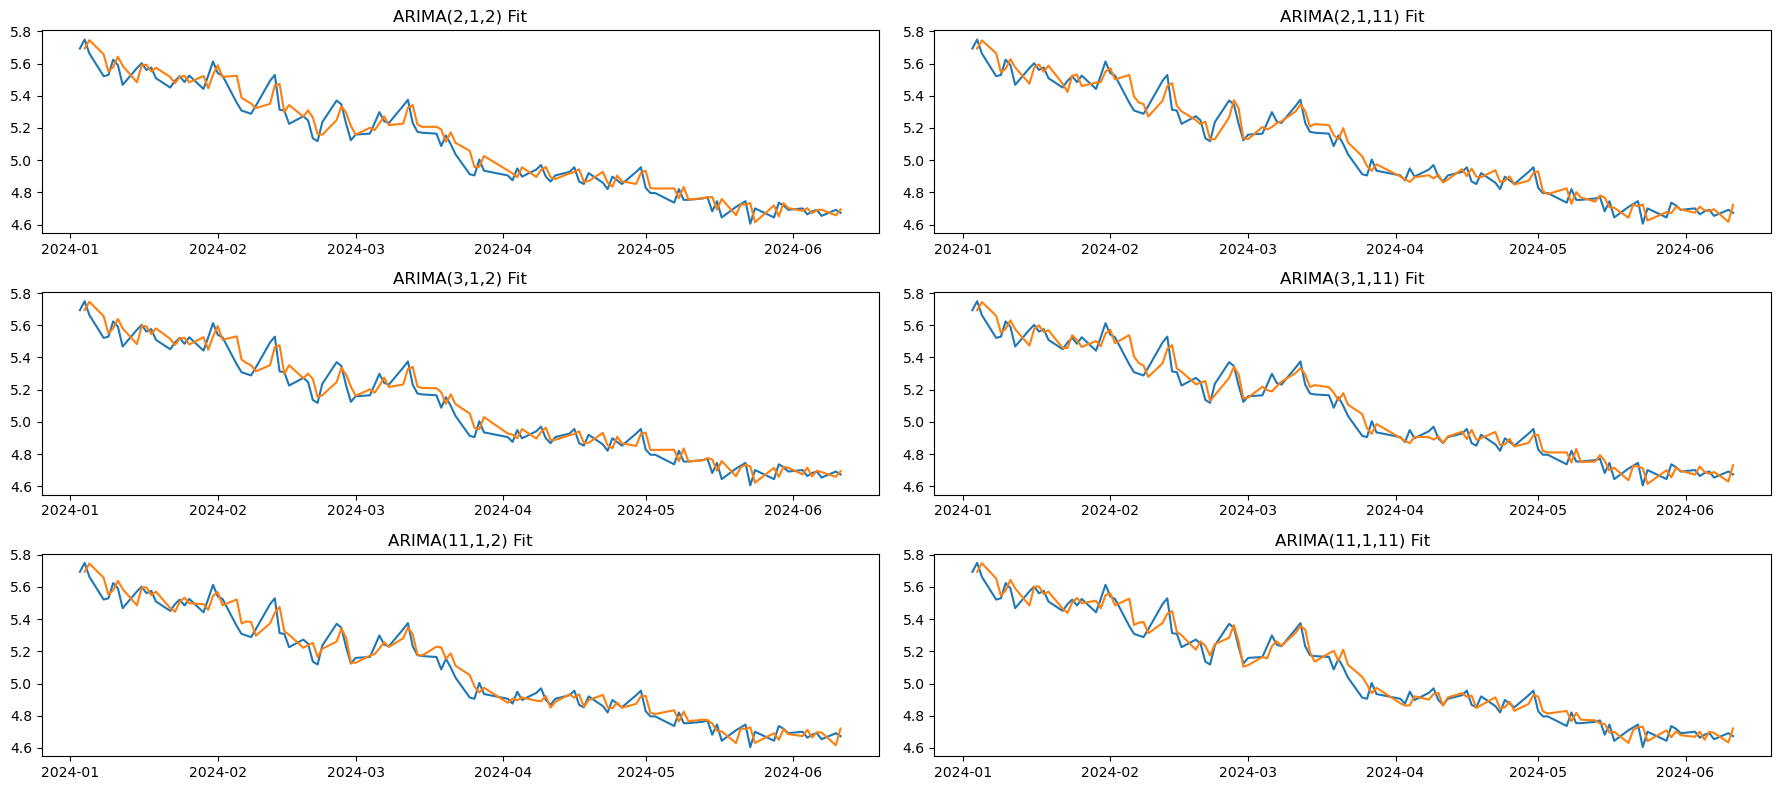

In [16]:
# model selection
ar_orders=[2,3,11]
ma_orders=[2,11]
fitted_model_dict={}
AIC_dict={}
fig,axes=plt.subplots(len(ar_orders),len(ma_orders),figsize=(18,8))
for idx, ar_order in enumerate(ar_orders):
    for idy, ma_order in enumerate(ma_orders):
        # create ARIMA model
        model=ARIMA(train_data, order=(ar_order,1,ma_order))
        model_fit = model.fit()
        fitted_model_dict[ar_order,ma_order]=model_fit
        AIC_dict[ar_order,ma_order]=fitted_model_dict[ar_order,ma_order].aic
        ax = axes[idx, idy]
        ax.set_title('ARIMA(%s,1,%s) Fit'%(ar_order,ma_order))
        ax.plot(train_data)
        ax.plot(model_fit.fittedvalues[1:])
plt.tight_layout()
for ar_order in ar_orders:
    for ma_order in ma_orders:
        print('AIC for ARIMA(%s,1,%s):%s'%(ar_order,ma_order,AIC_dict[ar_order,ma_order]))

In [17]:
# Sort the dictionary by value and return the first key-value pair
min_key, min_val = sorted(AIC_dict.items(), key=lambda x: x[1])[0]
print("The ARIMA model with the lowest AIC is: (%s,1,%s)"%(min_key[0],min_key[1]))

The ARIMA model with the lowest AIC is: (2,1,2)


Figure(1500x800)


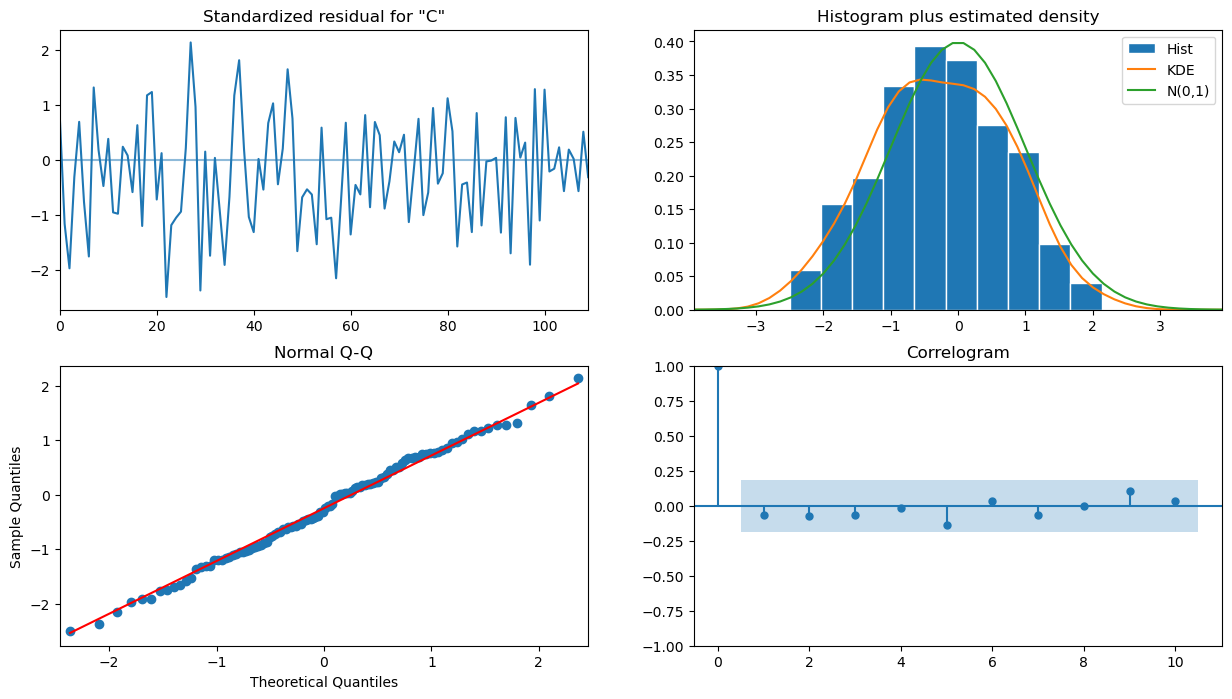

In [18]:
print(fitted_model_dict[min_key[0],min_key[1]].plot_diagnostics(figsize=(15,8)))

## Test the data

Date
2024-01-03    5.693732
2024-01-04    5.749393
2024-01-05    5.662960
2024-01-08    5.521461
2024-01-09    5.529429
                ...   
2024-06-05    4.682131
2024-06-06    4.691348
2024-06-07    4.653960
2024-06-10    4.691348
2024-06-11    4.672829
Name: Close, Length: 111, dtype: float64
Date
2024-01-03    0.000000
2024-01-04    5.693732
2024-01-05    5.745578
2024-01-08    5.657241
2024-01-09    5.550975
                ...   
2024-06-05    4.669918
2024-06-06    4.690390
2024-06-07    4.692502
2024-06-10    4.657318
2024-06-11    4.694343
Length: 111, dtype: float64


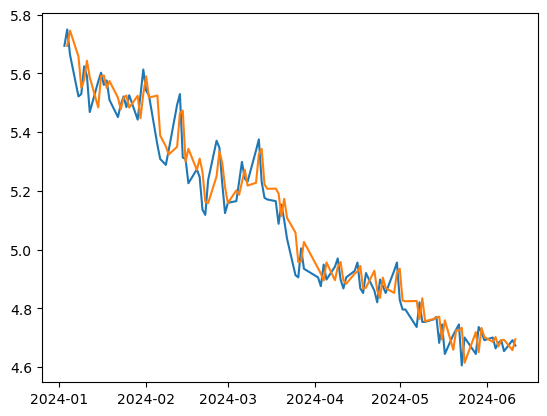

In [19]:
model_fit=fitted_model_dict[min_key[0],min_key[1]]
#model_fit=fitted_model_dict[3,2]
#get the predictions and residuals
predictions=model_fit.fittedvalues
# residuals = test_data - predictions
print(train_data)
print(predictions)
plt.plot(train_data)
plt.plot(predictions[1:])

In [20]:
pre_test=model_fit.forecast(steps=len(test_data))
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
print(pre_test)

111    4.671375
112    4.672748
113    4.674218
114    4.674718
115    4.674521
116    4.674203
117    4.674058
118    4.674076
119    4.674141
120    4.674179
121    4.674181
122    4.674168
123    4.674159
Name: predicted_mean, dtype: float64


/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
fc_series = pd.Series(np.array(pre_test), index=test_data.index)
fc_series

Date
2024-06-12    4.671375
2024-06-13    4.672748
2024-06-14    4.674218
2024-06-17    4.674718
2024-06-18    4.674521
2024-06-19    4.674203
2024-06-20    4.674058
2024-06-21    4.674076
2024-06-24    4.674141
2024-06-25    4.674179
2024-06-26    4.674181
2024-06-27    4.674168
2024-06-28    4.674159
dtype: float64

<Axes: xlabel='Date'>

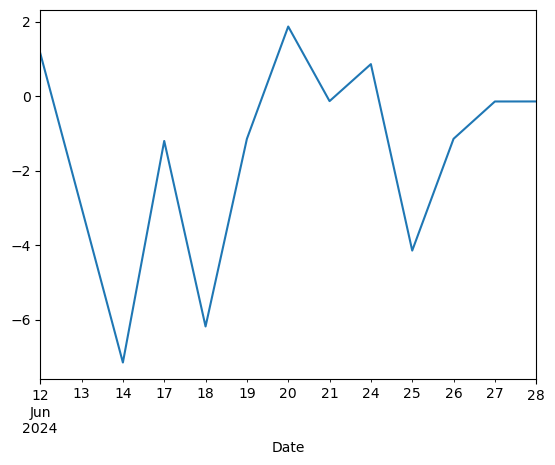

In [22]:
residuals=np.exp(test_data)-np.exp(fc_series)
residuals.plot()

RMSE: 3.1025094350826214
MAPE: 0.021105413464412512


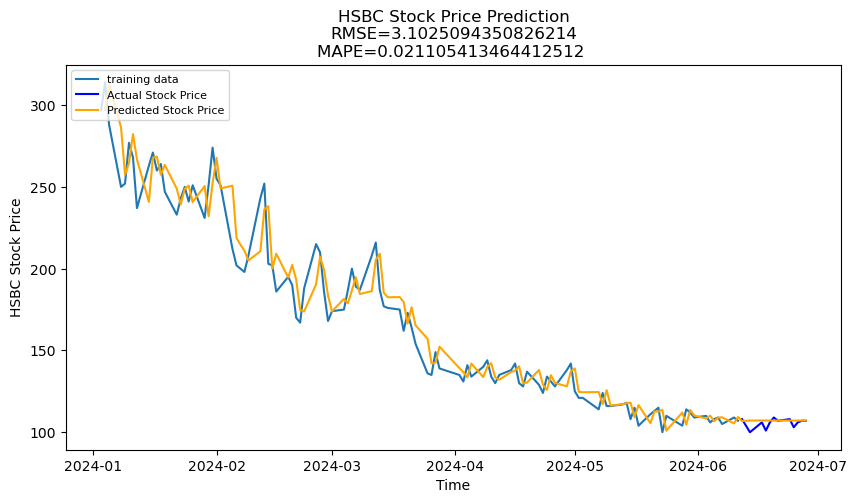

In [24]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
concat_df=[predictions[1:],fc_series]
pred_df=pd.concat(concat_df)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(pred_df), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('HSBC Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('HSBC Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Using Auto-ARIMA Model

# Rolling Forecasting Origin

In [25]:
# create the model
from datetime import timedelta
predictions_rolling=pd.Series()
for end_date in test_data.index:
    train_data=df_log[:end_date-timedelta(days=1)]
    model=ARIMA(train_data, order=(min_key[0],1,min_key[1]))
    model_fit=model.fit()
    pred=model_fit.forecast(steps=1)
    predictions_rolling.loc[end_date]=pred.values[0]
print(model_fit.summary)

/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_44572/2939406265.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling=pd.Series()
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so

<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x15b7e36a0>>


/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


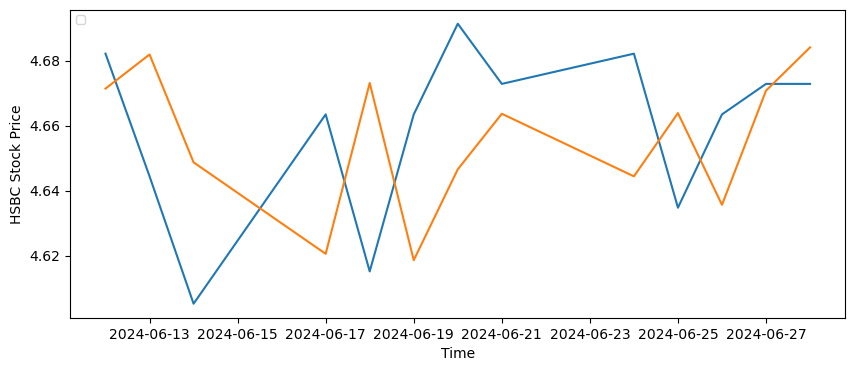

In [26]:
# draw the prediction plot
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling)

plt.xlabel('Time')
plt.ylabel('HSBC Stock Price')
plt.legend(loc='upper left', fontsize=8)

In [27]:
residuals_rolling=np.exp(test_data)-np.exp(predictions_rolling) # get the residuals
print(residuals_rolling)
print(predictions_rolling)

Date
2024-06-12    1.155447
2024-06-13   -3.972793
2024-06-14   -4.447622
2024-06-17    4.452532
2024-06-18   -6.029932
2024-06-19    4.651429
2024-06-20    4.777058
2024-06-21    0.979461
2024-06-24    4.001827
2024-06-25   -3.042618
2024-06-26    2.909351
2024-06-27    0.221967
2024-06-28   -1.208549
dtype: float64
2024-06-12    4.671375
2024-06-13    4.681879
2024-06-14    4.648686
2024-06-17    4.620526
2024-06-18    4.673109
2024-06-19    4.618566
2024-06-20    4.646532
2024-06-21    4.663633
2024-06-24    4.644373
2024-06-25    4.663841
2024-06-26    4.635609
2024-06-27    4.670752
2024-06-28    4.684060
dtype: float64


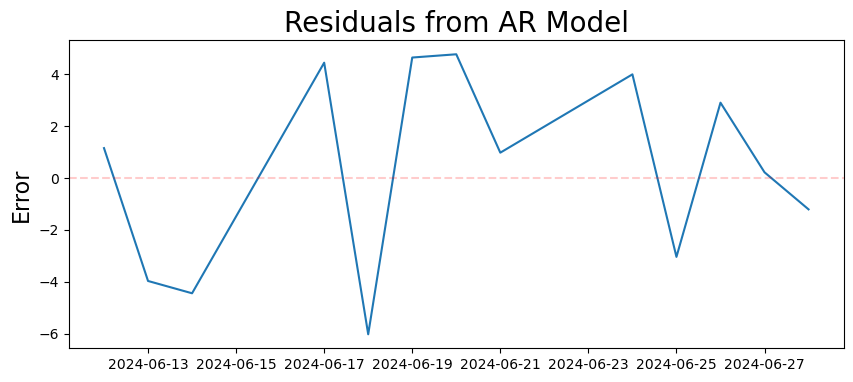

In [28]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)

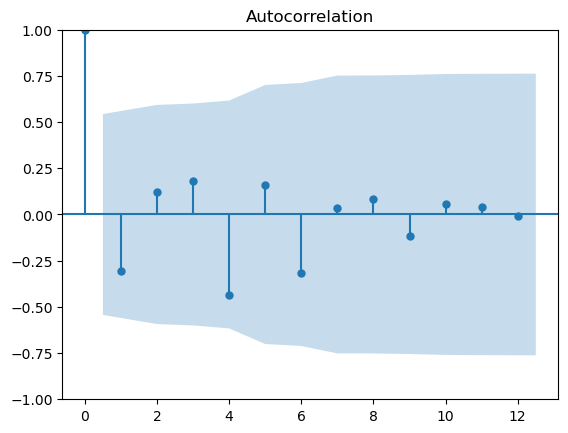

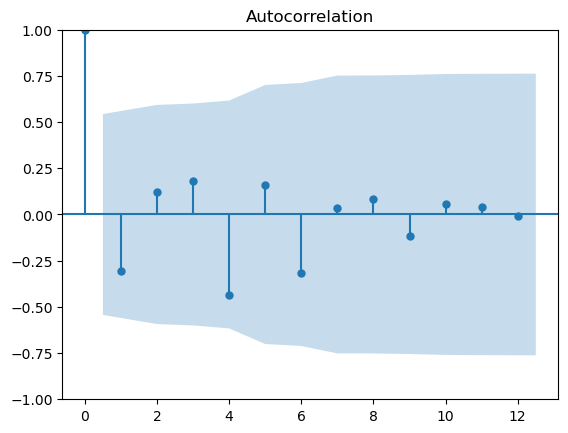

In [29]:
plot_acf(residuals_rolling,lags=12)

In [30]:
print('Mean Absolute Percent Error:',round(np.mean(abs(residuals_rolling/np.exp(test_data))),4))
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.0307
Root Mean Squared Error: 3.6558315379057986


RMSE: 3.6558315379057986
MAPE: 0.030719498587153306


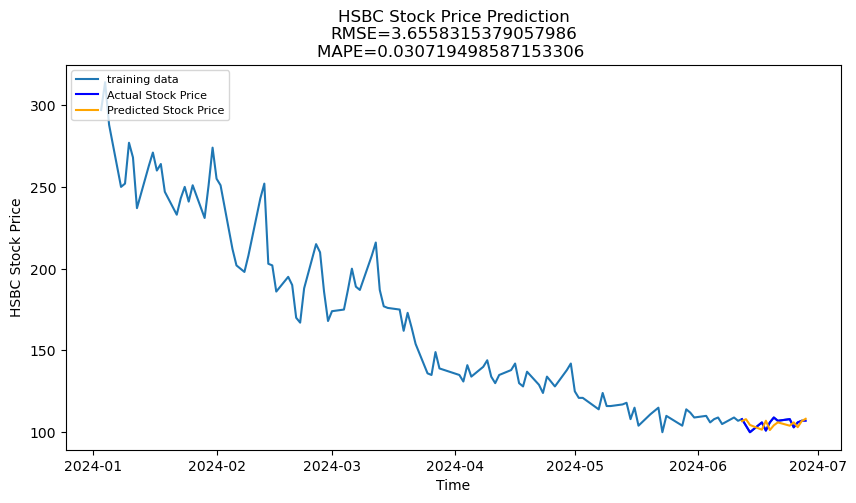

In [32]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(predictions_rolling), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(predictions_rolling)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals_rolling)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('HSBC Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('HSBC Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()